# Homework 5: Weather Prediction

## Due Tues Mar 8, 2022 @ 8 pm

## Casey Lam, casey_lam@berkeley.edu

## Collaborators: #hw5-discussion channel

In this assignment we will create a database to analyze historical weather data and discovery the relationships between major cities.

### 1) Use the data supplied of airport codes (ICAO_airports.csv) and top airports (top_airports.csv) to make a table of 50 most travelled airports in the US and containing relevant information, like name, wikipedia link, latitude, longitude.

In [1]:
import pandas as pd
import sqlite3

Load up the supplied data and take a look at what's in the tables.

In [2]:
icao = pd.read_csv('ICAO_airports.csv')
top = pd.read_csv('top_airports.csv')

In [3]:
icao.head(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,NaN,NaN,NaN
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,NaN,NaN,NaN


In [4]:
top.head(5)

,City,FAA,IATA,ICAO,Airport,Role,Enplanements
0,Atlanta,ATL,ATL,KATL,Hartsfield-Jackson Atlanta International Airport,P-L,43130585
1,Chicago,ORD,ORD,KORD,Chicago O'Hare International Airport,P-L,32171831
2,Los Angeles,LAX,LAX,KLAX,Los Angeles International Airport,P-L,30528737
3,Dallas-Fort Worth,DFW,DFW,KDFW,Dallas/Fort Worth International Airport,P-L,27100656
4,Denver,DEN,DEN,KDEN,Denver International Airport,P-L,25241962


Create the database, make two tables (icao, top), and put the relevant information from each csv file into the tables. 

In [5]:
!rm airports.db

connection = sqlite3.connect("airports.db")

cursor = connection.cursor()

sql_cmd = """CREATE TABLE icao 
            (iid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            name TEXT, 
            wikipedia_link TEXT, 
            iata TEXT, 
            latitude_deg FLOAT, 
            longitude_deg FLOAT)"""

cursor.execute(sql_cmd)

sql_cmd = """CREATE TABLE top 
            (tid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            name TEXT, 
            iata TEXT)"""

cursor.execute(sql_cmd)
connection.commit()

In [6]:
icao = icao.where(pd.notnull(icao), None)
for ii, row in icao.iterrows():
    iparams = (row['name'], row['wikipedia_link'], row['iata_code'], row['latitude_deg'], row['longitude_deg'])
    sql_cmd = """INSERT INTO icao
                (name, wikipedia_link, iata, latitude_deg, longitude_deg)
                VALUES (?, ?, ?, ?, ?)"""
    
    cursor.execute(sql_cmd, iparams)
connection.commit()

In [7]:
top = top.where(pd.notnull(top), None)
for ii, row in top.iterrows():
    iparams = (row['Airport'], row['IATA'])
    sql_cmd = """INSERT INTO top
                (name, iata)
                VALUES (?, ?)"""
    
    cursor.execute(sql_cmd, iparams)
connection.commit()    

In [8]:
# #########
# # Just to test and make sure this works.
# #########

# sql_cmd = "SELECT * FROM icao WHERE longitude_deg > 0"
# cursor.execute(sql_cmd)

# db_info = cursor.fetchall()
# for entry in db_info:
#     print(entry)

Now use left join and save the output as a new table called icao_top, which now is a table of the 50 most travelled airports in the US containing the airport name, IATA, wikipedia link, latitude, and longitude.

In [9]:
sql_cmd = """CREATE TABLE icao_top AS
            SELECT top.name, top.iata, icao.wikipedia_link, icao.latitude_deg, icao.longitude_deg
            FROM top LEFT JOIN icao ON
            top.iata = icao.iata"""

cursor.execute(sql_cmd)
connection.commit()

In [10]:
#########
# Just to make sure it worked.
#########

# sql_cmd = "SELECT * FROM icao_top"

# cursor.execute(sql_cmd)

# db_info = cursor.fetchall()
# print(len(db_info))
# for entry in db_info: 
#     print(entry)

### 2) Build another table that will hold historical weather information: min/max temperature, relative humidity, and precipitation.

In [11]:
sql_cmd = """CREATE TABLE weather
            (wid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            date DATE,
            lat FLOAT,
            long FLOAT,
            min_temp FLOAT,
            max_temp FLOAT,
            min_relhumid FLOAT,
            max_relhumid FLOAT,
            precip FLOAT)"""
cursor.execute(sql_cmd)
connection.commit()

### 3) Using the data from the xarray/netCDF4 example in class, populate the database from 1990-2000.

In [12]:
import xarray as xr
import numpy as np

Grab all the data we want (min/max temp, relative humidity, precipitation) from the online catalog.

In [13]:
# temp: tasmax/tasmin, RH: rhsmax/rhsmin, precipitation: pr
# downward shortwave solar radiation(rsds), eastward wind(uas), 
# northward wind(vas), and specific humidity(huss)

datatype = "tasmax" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

max_temp_xr_all = xr.open_dataset(data_path)  
max_temp_xr = max_temp_xr_all['air_temperature'].sel(time=slice("1990", "2000"))

In [14]:
datatype = "tasmin" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

min_temp_xr_all = xr.open_dataset(data_path)  
min_temp_xr = min_temp_xr_all['air_temperature'].sel(time=slice("1990", "2000"))

In [15]:
datatype = "rhsmax" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

max_rhum_xr_all = xr.open_dataset(data_path) 
max_rhum_xr = max_rhum_xr_all['relative_humidity'].sel(time=slice("1990", "2000"))

In [16]:
datatype = "rhsmin" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

min_rhum_xr_all = xr.open_dataset(data_path) 
min_rhum_xr = min_rhum_xr_all['relative_humidity'].sel(time=slice("1990", "2000"))

In [17]:
datatype = "pr" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

precip_xr_all = xr.open_dataset(data_path) 
precip_xr = precip_xr_all['precipitation'].sel(time=slice("1990", "2000"))

Just get the longitudes and latitudes that match those of the airports, otherwise it will take forever to make the database.

In [18]:
lon_arr = np.zeros(50)
lat_arr = np.zeros(50)

sql_cmd = "SELECT latitude_deg, longitude_deg FROM icao_top"

cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for ii, entry in enumerate(db_info): 
    lat_arr[ii] = entry[0]
    lon_arr[ii] = entry[1]

Only include the airports that have longitudes/latitudes that fall within the range spanned by the xarray/netCDF4 dataset.

In [19]:
# Figure out how the latitude/longitude values are spaced 
# so we can decide what falls within the dataset range.
lat_delta = np.diff(precip_xr['lat']).mean()
lon_delta = np.diff(precip_xr['lon']).mean()

lat_min = precip_xr['lat'].values.min()
lat_max = precip_xr['lat'].values.max()
lon_min = precip_xr['lon'].values.min()
lon_max = precip_xr['lon'].values.max()

idx = np.where((lon_arr + 360 > lon_min - lon_delta) &
               (lon_arr + 360 < lon_max + lon_delta) &
               (lat_arr > lat_min - lat_delta) &
               (lat_arr < lat_max + lat_delta))[0]

print('Number of airports with weather data : ', len(idx))

# Trim the longitudes and latitudes to only include the airports with weather data.
lon_arr = lon_arr[idx]
lat_arr = lat_arr[idx]
n_good = len(idx)

Number of airports with weather data :  48


Find the index of the closest latitude/longitude for the airport in the xarray/netCDF4 dataset.

In [20]:
lon_idx_arr = []
lat_idx_arr = []

for ii, lon in enumerate(lon_arr):
    lon_idx_arr.append(np.abs(precip_xr['lon'].values - (lon + 360)).argmin())

for ii, lat in enumerate(lat_arr):
    lat_idx_arr.append(np.abs(precip_xr['lat'].values - lat).argmin())

Make sure that we have something sensible. (And we do-- you can kinda see that the airports sort of fill in the area of the United States!)

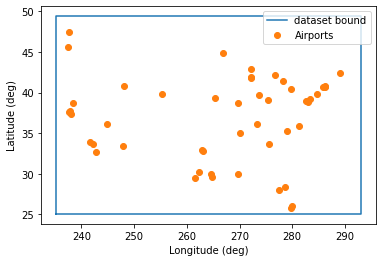

In [21]:
import matplotlib.pyplot as plt

lonidx = np.where(precip_xr['lon'].values[lon_idx_arr] - (lon_arr + 360) > 0.04)[0]
latidx = np.where(precip_xr['lat'].values[lat_idx_arr] - lat_arr > 0.04)[0]

plt.plot([precip_xr['lon'].min(), precip_xr['lon'].min(), precip_xr['lon'].max(), 
          precip_xr['lon'].max(), precip_xr['lon'].min()],
         [precip_xr['lat'].min(), precip_xr['lat'].max(), precip_xr['lat'].max(), 
          precip_xr['lat'].min(), precip_xr['lat'].min()],
         label='dataset bound')
plt.plot(lon_arr + 360, lat_arr, 'o', label='Airports')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.legend()

Fill up the database.

In [22]:
# ~1000 seconds to write the table.
import time
t1 = time.time()
for ii in np.arange(n_good):
    lon_idx = lon_idx_arr[ii]
    lat_idx = lat_idx_arr[ii]
    lat = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lat'].values
    lon = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lon'].values
    min_temp = min_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
    max_temp = max_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
    min_rhum = min_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
    max_rhum = max_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
    precip = precip_xr.isel(lon=lon_idx, lat=lat_idx).values
    for jj, time_xr in enumerate(precip_xr['time']):
        params = (str(time_xr.dt.strftime('%Y-%m-%d').values),
                  float(lat_arr[ii]),
                  float(lon_arr[ii]),
                  float(min_temp[jj]),
                  float(max_temp[jj]),
                  float(min_rhum[jj]),
                  float(max_rhum[jj]),
                  float(precip[jj]))
        sql_cmd = """INSERT INTO weather
                    (date, lat, long, min_temp, max_temp, min_relhumid, max_relhumid, precip)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?)"""
    
        cursor.execute(sql_cmd, params)
connection.commit()
t2 = time.time()

print(t2 - t1)

840.5787029266357


### 4) For each pair of cities/airports determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, & 7 days in advance. (Note: for correlations between pairs, try np.corrcoef.)

Get the maximum temperature and preciptation from the weather table for each (lat, long) pair and store them into arrays.

In [23]:
max_temp_arr = np.empty((n_good, 4018))

precip_arr = np.empty((n_good, 4018))

for ii in np.arange(n_good):
    sql_cmd = "SELECT max_temp, precip FROM weather WHERE lat={0} AND long={1} ORDER BY date".format(lat_arr[ii], lon_arr[ii])
    cursor.execute(sql_cmd)

    db_info = cursor.fetchall()
    for ee, entry in enumerate(db_info):
        max_temp_arr[ii, ee] = entry[0]
        precip_arr[ii, ee] = entry[1]

Get all possible combinations of pairs.

In [24]:
import itertools
combos = list(itertools.combinations(np.arange(n_good), 2))

d0_temp = np.empty(len(combos))
d1_temp = np.empty(len(combos))
d3_temp = np.empty(len(combos))
d7_temp = np.empty(len(combos))

d0_prec = np.empty(len(combos))
d1_prec = np.empty(len(combos))
d3_prec = np.empty(len(combos))
d7_prec = np.empty(len(combos))

Take the difference between dates (i.e. the daily change), then calculate the correlation between pairs, for a difference of 0, 1, 3, and 7 days.

In [25]:
for ii in np.arange(len(combos)):
    idx1 = combos[ii][0]
    idx2 = combos[ii][1]
    d0_temp[ii] = np.corrcoef(np.diff(max_temp_arr[idx1]), np.diff(max_temp_arr[idx2]))[0,1]
    d1_temp[ii] = np.corrcoef(np.diff(max_temp_arr[idx1])[1:], np.diff(max_temp_arr[idx2])[:-1])[0,1]
    d3_temp[ii] = np.corrcoef(np.diff(max_temp_arr[idx1])[3:], np.diff(max_temp_arr[idx2])[:-3])[0,1]
    d7_temp[ii] = np.corrcoef(np.diff(max_temp_arr[idx1])[7:], np.diff(max_temp_arr[idx2])[:-7])[0,1]
    
    d0_prec[ii] = np.corrcoef(np.diff(precip_arr[idx1]), np.diff(precip_arr[idx2]))[0,1]
    d1_prec[ii] = np.corrcoef(np.diff(precip_arr[idx1])[1:], np.diff(precip_arr[idx2])[:-1])[0,1]
    d3_prec[ii] = np.corrcoef(np.diff(precip_arr[idx1])[3:], np.diff(precip_arr[idx2])[:-3])[0,1]
    d7_prec[ii] = np.corrcoef(np.diff(precip_arr[idx1])[7:], np.diff(precip_arr[idx2])[:-7])[0,1]

For each pair, calculate their separation, and latitude and longitude differences.

In [26]:
sep = np.empty(len(combos))
dlon = np.empty(len(combos))
dlat = np.empty(len(combos))

lat_arr_rad = np.deg2rad(lat_arr)
lon_arr_rad = np.deg2rad(lon_arr)

for ii in np.arange(len(combos)):
    idx1 = combos[ii][0]
    idx2 = combos[ii][1]
    lat1 = lat_arr_rad[idx1]
    lat2 = lat_arr_rad[idx2]
    lon1 = lon_arr_rad[idx1]
    lon2 = lon_arr_rad[idx2]
    term1 = np.sin(0.5 * (lat2 - lat1))**2
    term2 = np.cos(lat1) * np.cos(lat2) * np.sin(0.5 * (lon2 - lon1))**2
    # This separation is the haversine distance, without the 2*radius.
    sep[ii] = np.arcsin(np.sqrt(term1 + term2))
    dlon[ii] = np.rad2deg(lon2 - lon1)
    dlat[ii] = np.rad2deg(lat2 - lat1)

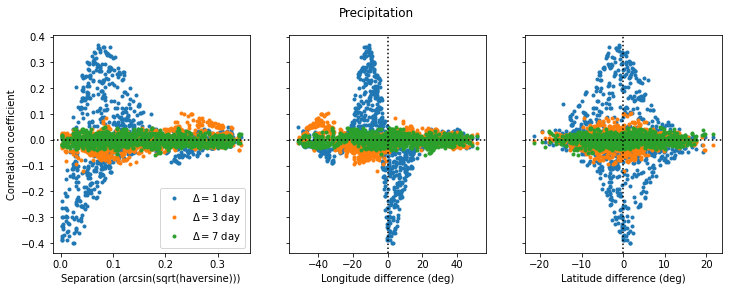

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)

ax[0].plot(sep, d1_prec, '.', label='$\Delta = 1$ day')
ax[0].plot(sep, d3_prec, '.', label='$\Delta = 3$ day')
ax[0].plot(sep, d7_prec, '.', label='$\Delta = 7$ day')
ax[0].legend()
ax[0].set_xlabel('Separation (arcsin(sqrt(haversine)))')
ax[0].set_ylabel('Correlation coefficient')
ax[0].axhline(y=0, color='k', ls = ':')

ax[1].plot(dlon, d1_prec, '.', label='$\Delta = 1$ day')
ax[1].plot(dlon, d3_prec, '.', label='$\Delta = 3$ day')
ax[1].plot(dlon, d7_prec, '.', label='$\Delta = 7$ day')
ax[1].set_xlabel('Longitude difference (deg)')
ax[1].axvline(x=0, color='k', ls=':')
ax[1].axhline(y=0, color='k', ls = ':')

ax[2].plot(dlat, d1_prec, '.', label='$\Delta = 1$ day')
ax[2].plot(dlat, d3_prec, '.', label='$\Delta = 3$ day')
ax[2].plot(dlat, d7_prec, '.', label='$\Delta = 7$ day')
ax[2].set_xlabel('Latitude difference (deg)')
plt.axvline(x=0, color='k', ls=':')
plt.axhline(y=0, color='k', ls = ':')

plt.suptitle('Precipitation')
plt.show()

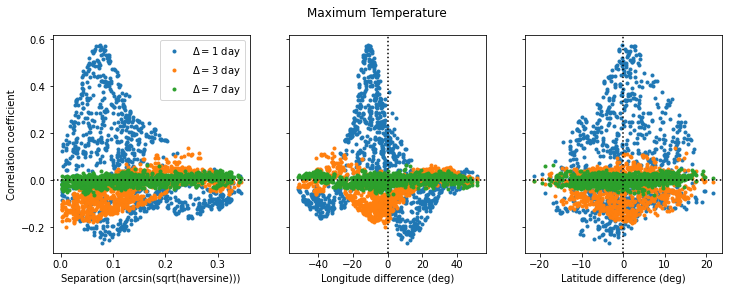

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)

ax[0].plot(sep, d1_temp, '.', label='$\Delta = 1$ day')
ax[0].plot(sep, d3_temp, '.', label='$\Delta = 3$ day')
ax[0].plot(sep, d7_temp, '.', label='$\Delta = 7$ day')
ax[0].legend()
ax[0].set_xlabel('Separation (arcsin(sqrt(haversine)))')
ax[0].set_ylabel('Correlation coefficient')
ax[0].axhline(y=0, color='k', ls = ':')

ax[1].plot(dlon, d1_temp, '.', label='$\Delta = 1$ day')
ax[1].plot(dlon, d3_temp, '.', label='$\Delta = 3$ day')
ax[1].plot(dlon, d7_temp, '.', label='$\Delta = 7$ day')
ax[1].set_xlabel('Longitude difference (deg)')
ax[1].axvline(x=0, color='k', ls=':')
ax[1].axhline(y=0, color='k', ls = ':')

ax[2].plot(dlat, d1_temp, '.', label='$\Delta = 1$ day')
ax[2].plot(dlat, d3_temp, '.', label='$\Delta = 3$ day')
ax[2].plot(dlat, d7_temp, '.', label='$\Delta = 7$ day')
ax[2].set_xlabel('Latitude difference (deg)')
plt.axvline(x=0, color='k', ls=':')
plt.axhline(y=0, color='k', ls = ':')

plt.suptitle('Maximum Temperature')
plt.show()

As a sanity check, let's check for same date.

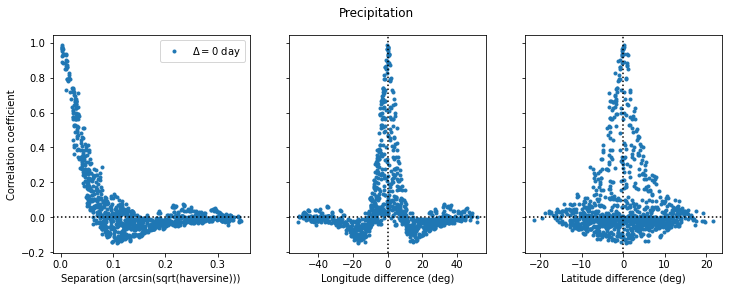

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)

ax[0].plot(sep, d0_prec, '.', label='$\Delta = 0$ day')
ax[0].legend()
ax[0].set_xlabel('Separation (arcsin(sqrt(haversine)))')
ax[0].set_ylabel('Correlation coefficient')
ax[0].axhline(y=0, color='k', ls = ':')

ax[1].plot(dlon, d0_prec, '.', label='$\Delta = 0$ day')
ax[1].set_xlabel('Longitude difference (deg)')
ax[1].axvline(x=0, color='k', ls=':')
ax[1].axhline(y=0, color='k', ls = ':')

ax[2].plot(dlat, d0_prec, '.', label='$\Delta = 0$ day')
ax[2].set_xlabel('Latitude difference (deg)')
plt.axvline(x=0, color='k', ls=':')
plt.axhline(y=0, color='k', ls = ':')

plt.suptitle('Precipitation')
plt.show()

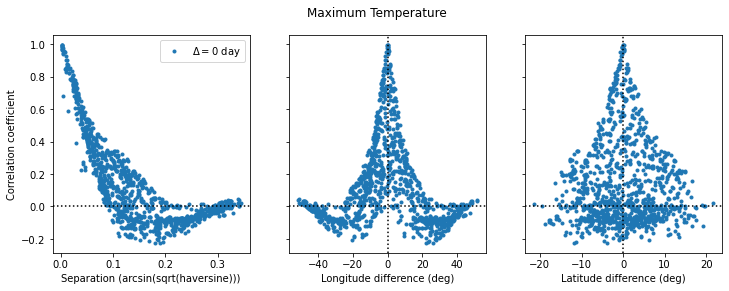

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)

ax[0].plot(sep, d0_temp, '.', label='$\Delta = 0$ day')
ax[0].legend()
ax[0].set_xlabel('Separation (arcsin(sqrt(haversine)))')
ax[0].set_ylabel('Correlation coefficient')
ax[0].axhline(y=0, color='k', ls = ':')

ax[1].plot(dlon, d0_temp, '.', label='$\Delta = 0$ day')
ax[1].set_xlabel('Longitude difference (deg)')
ax[1].axvline(x=0, color='k', ls=':')
ax[1].axhline(y=0, color='k', ls = ':')

ax[2].plot(dlat, d0_temp, '.', label='$\Delta = 0$ day')
ax[2].set_xlabel('Latitude difference (deg)')
plt.axvline(x=0, color='k', ls=':')
plt.axhline(y=0, color='k', ls = ':')

plt.suptitle('Maximum Temperature')
plt.show()

Correlations peak at separations of zero, as well as longitude and latitude differences of zero. This is what you expect since you'd expect weather at nearby locations to be very similar. Good! 

### 5) Plot the correlation strengths for the 10 top pairs for all three dates, for temperature and precipitation (separately) as a function of distance. Also make a plot as a function of longitude difference. What trends do you see?

Sort the arrays in order of increasing correlation coefficient.

In [31]:
d0_temp_sortidx = np.argsort(d0_temp)
d1_temp_sortidx = np.argsort(d1_temp)
d3_temp_sortidx = np.argsort(d3_temp)
d7_temp_sortidx = np.argsort(d7_temp)

d0_prec_sortidx = np.argsort(d0_prec)
d1_prec_sortidx = np.argsort(d1_prec)
d3_prec_sortidx = np.argsort(d3_prec)
d7_prec_sortidx = np.argsort(d7_prec)

Since argsort does increasing, flip the array (so we get the maximum correlation coefficients) and then take the top 10 values.

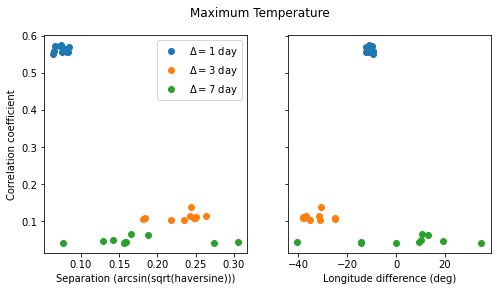

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax[0].plot(sep[d1_temp_sortidx][::-1][0:10], d1_temp[d1_temp_sortidx][::-1][0:10], 'o', label='$\Delta = 1$ day')
ax[0].plot(sep[d3_temp_sortidx][::-1][0:10], d3_temp[d3_temp_sortidx][::-1][0:10], 'o', label='$\Delta = 3$ day')
ax[0].plot(sep[d7_temp_sortidx][::-1][0:10], d7_temp[d7_temp_sortidx][::-1][0:10], 'o', label='$\Delta = 7$ day')
ax[0].set_xlabel('Separation (arcsin(sqrt(haversine)))')
ax[0].set_ylabel('Correlation coefficient')
ax[0].legend()

ax[1].plot(dlon[d1_temp_sortidx][::-1][0:10], d1_temp[d1_temp_sortidx][::-1][0:10], 'o', label='$\Delta = 1$ day')
ax[1].plot(dlon[d3_temp_sortidx][::-1][0:10], d3_temp[d3_temp_sortidx][::-1][0:10], 'o', label='$\Delta = 3$ day')
ax[1].plot(dlon[d7_temp_sortidx][::-1][0:10], d7_temp[d7_temp_sortidx][::-1][0:10], 'o', label='$\Delta = 7$ day')
ax[1].set_xlabel('Longitude difference (deg)')

plt.suptitle('Maximum Temperature')

plt.show()

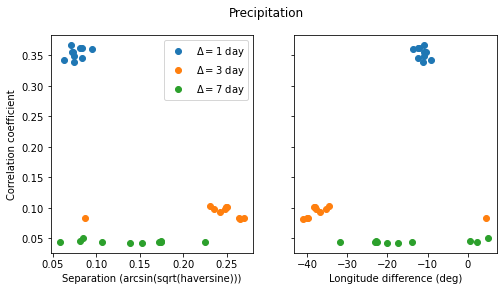

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax[0].plot(sep[d1_prec_sortidx][::-1][0:10], d1_prec[d1_prec_sortidx][::-1][0:10], 'o', label='$\Delta = 1$ day')
ax[0].plot(sep[d3_prec_sortidx][::-1][0:10], d3_prec[d3_prec_sortidx][::-1][0:10], 'o', label='$\Delta = 3$ day')
ax[0].plot(sep[d7_prec_sortidx][::-1][0:10], d7_prec[d7_prec_sortidx][::-1][0:10], 'o', label='$\Delta = 7$ day')
ax[0].set_xlabel('Separation (arcsin(sqrt(haversine)))')
ax[0].set_ylabel('Correlation coefficient')
ax[0].legend()

ax[1].plot(dlon[d1_prec_sortidx][::-1][0:10], d1_prec[d1_prec_sortidx][::-1][0:10], 'o', label='$\Delta = 1$ day')
ax[1].plot(dlon[d3_prec_sortidx][::-1][0:10], d3_prec[d3_prec_sortidx][::-1][0:10], 'o', label='$\Delta = 3$ day')
ax[1].plot(dlon[d7_prec_sortidx][::-1][0:10], d7_prec[d7_prec_sortidx][::-1][0:10], 'o', label='$\Delta = 7$ day')
ax[1].set_xlabel('Longitude difference (deg)')

plt.suptitle('Precipitation')

plt.show()